# Problem 1: Data with R

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

library(tidyverse)

/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Conflicts with tidy packages ---------------------------------------------------

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: filter(): dplyr, stats
lag():    dplyr, stats

  warnings.warn(x, RRuntimeWarning)


In [59]:
%%R
# make sure to get your data in the same folder, next to the notebook file
# so that this will run!


dat <- read_csv('classification_data.csv')

/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Parsed with column specification:
cols(
  X = col_double(),
  label = col_integer()
)

  warnings.warn(x, RRuntimeWarning)


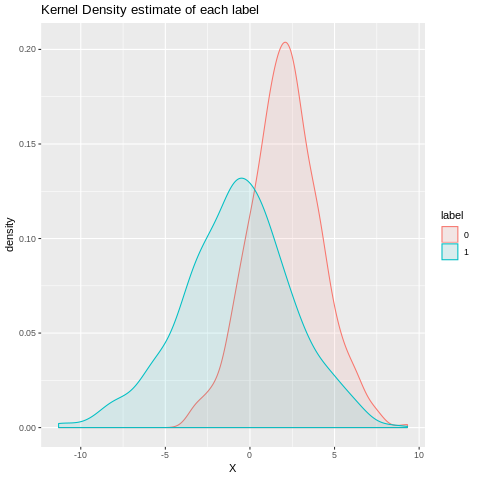

In [67]:
%%R

# Your data consists of an "X" column and a "label" column
# Use ggplot to plot a kernel density estimate of each label (overlayed on the same plot)
# hint: don't forget to make sure the labels are factors!

# we convert labels to factors
# mutate adds new variables and preserves existing; transmute drops existing variables
# parse_factor is similar to factor(), but will generate warnings if elements of x are not found in levels

dat <- dat %>% 
    mutate(label = parse_factor(label, levels = NULL))

# dat$label <- as.factor(dat$label) would work as well, as.factor() converts a column into a factor column

dat_factor %>% 
    group_by(label) %>% 
        ggplot(aes(x = X, colour = label, fill = label)) +
        geom_density(alpha = 0.1) + 
        ggtitle("Kernel Density estimate of each label") 


# Problem 2: Using Classes in Python

In [36]:
from abc import ABC, abstractmethod
from math import sqrt

def smart_zip(a,b): # defines a smart zip function
    try:
        return zip(a, b)
    except TypeError:
        return zip([a], [b])

class AbstractKNeighbors(ABC):
    def __init__(self, K): # __init__ is the contructor
        self.K = K

    def fit(self, X, y): # fit is a method
        """ Train the model!

        X should be a list of data points
        y should be a list of labels
        """
        self.X = X
        self.y = y
        return self

    @abstractmethod
    def _make_prediction(self, labels):
        pass # pass is commonly used as a placeholder, as if there's a method that you don't want to implement yet

    def predict(self, new_x):
        """Find the nearest K neighbors
        
        new_x should be a single data point
        """

        dists = [sqrt(sum(([(i-j)**2 for i,j in smart_zip(x,new_x)])))
                 for x in self.X]
        sorted_neighbors = sorted(enumerate(dists),
                                  key=lambda t: t[1])
        labels = [self.y[i] for i,_ in sorted_neighbors]
        return self._make_prediction(labels)


class KNearestNeighbors(AbstractKNeighbors):
    def _make_prediction(self, labels):
        avg = sum(labels[:self.K])/self.K
        return round(avg)

class KFurthestNeighbors(AbstractKNeighbors):
    def _make_prediction(self, labels):
        avg = sum(labels[-self.K:])/self.K
        return round(1 - avg)

In [37]:
from csv import reader

with open('classification_data.csv', 'r') as f:
    dat = list(reader(f))[1:]
    dat = [[float(x), int(label)] for x,label in dat]

## Problem 2.1: Shuffling!

In [53]:
# In your data, "X" is a data point that is nothing more than
# a single number. 
# Shuffle your data into a random order (use random.shuffle!)

import random

random.shuffle(dat)

In [54]:
# If you shuffled your data, this test should pass
# (i.e. not throw an error)

assert(sum([label for x,label in dat[:50]]) != 0)

## Problem 2.2: Splitting!

In [69]:
# Split your data, which is now a list, into 2 sublists:
# "train" and "test"
# The "train" group should have 700 elements
# The test group should have 300 elements
# Each group should have the same format as the original data

train_dat = dat[:700]
test_dat = dat[700:]

print(len(train_dat))
print(len(test_dat))

700
300


In [82]:
# Now you will need to make another split, within the groups!
# For each group ("train" and "test") split the X's from the labels.

train_X = [X for X, labels in train_dat]
train_labels = [labels for X, labels in train_dat]

test_X = [X for X, labels in test_dat]
test_labels = [labels for X, labels in test_dat]

In [80]:
# Another way to split is to deconstruct the lists using zip and * - basically the opposite of zip
# train_X, train_label = zip(*train_dat)
# test_X, test_label = zip(*test_dat)

## Problem 2.3: Testing models!

In [83]:
# For each model: 
# 1. Create an instance the class, with constructor parameters: K=5
#Simply initalize the two different models
model_n = KNearestNeighbors(K = 5)
model_f = KFurthestNeighbors(K = 5)

# 2. Train the instance on the "train" groups X's and labels (y's)
#Call the fit method of the models - basically just stores the data into our models
model_n_fit = model_n.fit(train_X, train_labels)
model_f_fit = model_f.fit(train_X, train_labels)

# 3. Test how well the instance does: 
#    A. Use the trained instance to predict the label of each "X" in the "test" group
# We have to call the predict method for each new X we want to predict - list comprehension like this
# is much cleaner than a for loop
pred_labels_n = [model_n_fit.predict(x) for x in test_X]
pred_labels_f = [model_f_fit.predict(x) for x in test_X]

#    B. Use your "test" labels to see if the predicted label is equal the true label
# Again we use list comprehension in place of a loop to go over all the predicted values
# We have to zip the predictions and actual values into one list in order to do the pred==act comparison like this
correct_n = [pred == act for pred, act in zip(pred_labels_n, test_labels)]
correct_f = [pred == act for pred, act in zip(pred_labels_f, test_labels)]

In [84]:
# Compare the two classes of models!
#Summing up the Boolean list we created above tells us the number of correct predictions
print("Nearest Neighbors correct predictions:", sum(correct_n), "or,", 
      round(sum(correct_n)/len(test_y)*100,1), "percent")
print("Furthest Neighbors correct predictions:", sum(correct_f), "or,", 
      round(sum(correct_f)/len(test_y)*100,1), "percent")

Nearest Neighbors correct predictions: 204 or, 68.0 percent
Furthest Neighbors correct predictions: 195 or, 65.0 percent


In [85]:
if sum(correct_n) > sum(correct_f):
    print("Nearest Neighbors was more accurate")
elif sum(correct_n) < sum(correct_f):
    print("Furthest Neighbors was more accurate!")
else:
    print("Models got the same number correct")

Nearest Neighbors was more accurate
